# Set Up

## Overview

Plan: integrate normal (atlas) with T21 data

`cell_type_key` will be a modification of `mid_grain` labels from the atlas.

Modified because the `CardiacConductionSystem` cells in the `mid_grain` category are functionally linked, but transcriptionally distinct. For scANVI we want labels to reflect transcriptionally close cells.

`batch_key` will be `batch_key` (donor, kit, cell v nuclei, which is present on both objects)

For both datasets:
- `"counts"` layer containing raw counts
- `.X` contains norm-logged data
- features will be the HVGs **from the reference atlas** (so features are the same across both datasets)

https://docs.scarches.org/en/latest/scanvi_surgery_pipeline.html

In [1]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import os
import gdown

INFO:lightning_fabric.utilities.seed:Global seed set to 0
 captum (see https://github.com/pytorch/captum).


In [2]:
# Prints current CPU and GPU RAM usage
import psutil
import os

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    total_memory = psutil.virtual_memory().total
    
    relative_memory = (mem_info.rss / total_memory) * 100
    
    print(f"Absolute memory usage: {round(mem_info.rss / 1024 ** 2)} MB")
    print(f"Relative memory usage: {round(relative_memory)}%")
    
import GPUtil
def print_gpu_usage():
    GPUs = GPUtil.getGPUs()
    for i, gpu in enumerate(GPUs):
        print(f"GPU {i}: {round(gpu.load*100, 2)}%")

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
%%bash
nvidia-smi

Fri Jul 21 14:54:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   32C    P0    39W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Paths & variables

In [5]:
#set relevant label key
compartment='AllCompartments'
cell_type_key = 'MidGrainModified'
batch_key='batch_key'
job_name=f'AtlasT21_WithContCovariates_{cell_type_key}_{compartment}'
job_name

'AtlasT21_WithContCovariates_MidGrainModified_AllCompartments'

In [6]:
#paths
base_path='/lustre/scratch126/cellgen/team205/jc48/jupyter/scArches'
data_dir=os.path.join(base_path,'data')
results_dir=os.path.join(base_path,f'results/{job_name}')
adata_path=os.path.join(results_dir,'anndata/')
models_path=os.path.join(results_dir,'models/')


#make directories
os.makedirs(data_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(adata_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

# Read in data

## Reference data

In [7]:
adata_ref = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw.h5ad')

adata_ref.var['mt'] = adata_ref.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes
adata_ref.var['ribo'] = adata_ref.var_names.str.startswith('RPS','RPL')  # annotate the group of ribosomal genes
sc.pp.calculate_qc_metrics(adata_ref, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

print(adata_ref.X.data[:10])

adata_ref.layers["counts"]=adata_ref.X.copy()

sc.pp.normalize_total(adata_ref,target_sum=1e4)
sc.pp.log1p(adata_ref)

sc.pp.highly_variable_genes(adata_ref, batch_key=batch_key)

print(adata_ref.shape)
adata_ref = adata_ref[:, adata_ref.var.highly_variable]

# Modify the mid_grain label since the CCS cells bridge two major clusters
rename_dict = {
    "SinoatrialNodeCardiomyocytes": "AtrialCardiomyocytes",
    "AtrioventricularNodeCardiomyocytes": "AtrialCardiomyocytes",
    "VentricularConductionSystemDistal": "VentricularCardiomyocytes",
    "VentricularConductionSystemProximal": "VentricularCardiomyocytes"
}

# Create the "MidGrainModified" column using the mapping logic
adata_ref.obs["MidGrainModified"] = adata_ref.obs["fine_grain"].map(rename_dict).fillna(adata_ref.obs["mid_grain"])

print('data prepared...')
print(adata_ref.X.data[:10])
print(adata_ref.shape)

[ 1.  1.  5.  5.  8.  4. 13.  4.  3.  1.]
(297473, 36601)


/tmp/ipykernel_56384/227930604.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs["MidGrainModified"] = adata_ref.obs["fine_grain"].map(rename_dict).fillna(adata_ref.obs["mid_grain"])


data prepared...
[0.42 0.34 1.12 0.1  0.34 0.34 0.27 0.1  0.19 1.08]
(297473, 3392)


The data is raw counts and has all features.
We:
- Calculate QC metrics (to be used as covariates), in case the object has been subset since this was last done
- store counts in "counts" layer.
- Norm-Log
- Calculate HVGs
- Subset to those
- Add a custom cell type label

## Target data

In [8]:
file_path=os.path.join(data_dir,'T21HeartsExtracardiacRemovedRaw.h5ad')
adata_que=sc.read(file_path)

adata_que.var['mt'] = adata_que.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes
adata_que.var['ribo'] = adata_que.var_names.str.startswith('RPS','RPL')  # annotate the group of ribosomal genes
sc.pp.calculate_qc_metrics(adata_que, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

print(adata_que.X.data[:10])
adata_que.layers["counts"] = adata_que.X.copy()
sc.pp.normalize_total(adata_que,target_sum=1e4)
sc.pp.log1p(adata_que)
adata_que.raw = adata_que
adata_que = adata_que[:,adata_ref.var_names]

print('data prepared...')
print(adata_que.X.data[:10])
print(adata_que.shape)

[ 3.  1.  1.  2. 24.  7.  4.  1.  1. 14.]
data prepared...
[0.5  0.32 0.09 0.25 0.17 0.79 0.38 0.09 0.17 0.25]
(76358, 3392)


Similarly, data is raw counts and has all features.
We:
- Calculate QC metrics (to be used as covariates), in case the object has been subset since this was last done
- store counts in "counts" layer.
- Norm-Log
- **Subset to match the HVGs of the reference**

# Make reference model

In [9]:
# set up the anndata
sca.models.SCVI.setup_anndata(adata_ref,
                              batch_key=batch_key,
                              labels_key=cell_type_key,
                              continuous_covariate_keys=['total_counts','pct_counts_mt','pct_counts_ribo'],# consider ['S_score','G2M_score']
                              layer="counts")

In [10]:
# initialise the VAE model
vae = sca.models.SCVI(
    adata_ref,
    n_hidden = 128, n_latent = 50, n_layers = 3, dispersion = 'gene-batch',
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [11]:
vae.view_anndata_setup(adata_ref)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch_key',
│   'labels_key': 'MidGrainModified',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   21   │
│         n_cells          │ 297473 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   3    │
│         n_labels         │   13   │
│          n_vars          │  3392  │
└──────────────────────────┴────────┘

                            Data Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Registry Key      ┃            scvi-tools Location            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X           │          adata.layers['counts']           │
│         batch         │         adata.obs['_scvi_batch']          │
│ extra_continuous_covs │ adata.obsm['_scvi_extra_continuous_covs'] │
│        labels         │         adata.obs['_scvi_labels']         │
└───────────────────────┴───────────────────────────────────────────┘

                           batch State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  BRC2251_Cell_3prime-v3  │          0          │
│                        │  BRC2252_Cell_3prime-v3  │          1          │
│                        │  BRC2256_Cell_3prime-v3  │          2          │
│                        │  BRC2260_Cell_3prime-v3  │          3          │
│                        │  BRC2262_Cell_3prime-v3  │          4          │
│                        │  BRC2263_Cell_3prime-v3  │          5          │
│                        │  C82_Nuclei_Multiome-v1  │          6          │
│                        │  C85_Nuclei_Multiome-v1  │          7          │
│                        │    C86_Cell_5prime-v2    │          8          │
│                        │  C87_Nuclei_Multiome-v1  │          9          │
│                        │  C92_Nuclei_Multiome-v1  │         10          │
│                        │    C94_Cell_5prime-v2    │         11          │
│                        │    C97_Cell_5prime-v2    │         12          │
│                        │  C98_Nuclei_Multiome-v1  │         13          │
│                        │    C99_Cell_5prime-v2    │         14          │
│                        │ C104_Nuclei_Multiome-v1  │         15          │
│                        │ Hst33_Nuclei_Multiome-v1 │         16          │
│                        │ Hst36_Nuclei_Multiome-v1 │         17          │
│                        │ Hst39_Nuclei_Multiome-v1 │         18          │
│                        │ Hst40_Nuclei_Multiome-v1 │         19          │
│                        │ Hst41_Nuclei_Multiome-v1 │         20          │
└────────────────────────┴──────────────────────────┴─────────────────────┘

                                labels State Registry                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['MidGrainModified'] │    AtrialCardiomyocytes     │          0          │
│                               │ BloodVesselEndothelialCells │          1          │
│                               │      EndocardialCells       │          2          │
│                               │       EpicardialCells       │          3          │
│                               │         Fibroblasts         │          4          │
│                               │            Glia             │          5          │
│                               │  LymphaticEndothelialCells  │          6          │
│                               │        LymphoidCells        │          7          │
│                               │         MuralCells          │          8          │
│                               │        MyeloidCells         │          9          │
│                               │           Neurons           │         10          │
│                               │      PericardialCells       │         11          │
│                               │  VentricularCardiomyocytes  │         12          │
└───────────────────────────────┴─────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
└──────────────────────────────┘

In [12]:
# Train the VAE
vae.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27/27: 100%|███████████████████████| 27/27 [18:01<00:00, 41.64s/it, loss=986, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.


Epoch 27/27: 100%|███████████████████████| 27/27 [18:01<00:00, 40.04s/it, loss=986, v_num=1]


In [13]:
# Initialise a SCANVI model from the VAE
scanvae = sca.models.SCANVI.from_scvi_model(vae,unlabeled_category = "Unknown")

In [14]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  297473
Unlabelled Indices:  0


In [15]:
scanvae.view_anndata_setup(adata_ref)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'MidGrainModified',
│   'unlabeled_category': 'Unknown',
│   'layer': 'counts',
│   'batch_key': 'batch_key',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   21   │
│         n_cells          │ 297473 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   3    │
│         n_labels         │   14   │
│          n_vars          │  3392  │
└──────────────────────────┴────────┘

                            Data Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Registry Key      ┃            scvi-tools Location            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X           │          adata.layers['counts']           │
│         batch         │         adata.obs['_scvi_batch']          │
│ extra_continuous_covs │ adata.obsm['_scvi_extra_continuous_covs'] │
│        labels         │         adata.obs['_scvi_labels']         │
└───────────────────────┴───────────────────────────────────────────┘

                           batch State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  BRC2251_Cell_3prime-v3  │          0          │
│                        │  BRC2252_Cell_3prime-v3  │          1          │
│                        │  BRC2256_Cell_3prime-v3  │          2          │
│                        │  BRC2260_Cell_3prime-v3  │          3          │
│                        │  BRC2262_Cell_3prime-v3  │          4          │
│                        │  BRC2263_Cell_3prime-v3  │          5          │
│                        │  C82_Nuclei_Multiome-v1  │          6          │
│                        │  C85_Nuclei_Multiome-v1  │          7          │
│                        │    C86_Cell_5prime-v2    │          8          │
│                        │  C87_Nuclei_Multiome-v1  │          9          │
│                        │  C92_Nuclei_Multiome-v1  │         10          │
│                        │    C94_Cell_5prime-v2    │         11          │
│                        │    C97_Cell_5prime-v2    │         12          │
│                        │  C98_Nuclei_Multiome-v1  │         13          │
│                        │    C99_Cell_5prime-v2    │         14          │
│                        │ C104_Nuclei_Multiome-v1  │         15          │
│                        │ Hst33_Nuclei_Multiome-v1 │         16          │
│                        │ Hst36_Nuclei_Multiome-v1 │         17          │
│                        │ Hst39_Nuclei_Multiome-v1 │         18          │
│                        │ Hst40_Nuclei_Multiome-v1 │         19          │
│                        │ Hst41_Nuclei_Multiome-v1 │         20          │
└────────────────────────┴──────────────────────────┴─────────────────────┘

                                labels State Registry                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['MidGrainModified'] │    AtrialCardiomyocytes     │          0          │
│                               │ BloodVesselEndothelialCells │          1          │
│                               │      EndocardialCells       │          2          │
│                               │       EpicardialCells       │          3          │
│                               │         Fibroblasts         │          4          │
│                               │            Glia             │          5          │
│                               │  LymphaticEndothelialCells  │          6          │
│                               │        LymphoidCells        │          7          │
│                               │         MuralCells          │          8          │
│                               │        MyeloidCells         │          9          │
│                               │           Neurons           │         10          │
│                               │      PericardialCells       │         11          │
│                               │  VentricularCardiomyocytes  │         12          │
│                               │           Unknown           │         13          │
└───────────────────────────────┴─────────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
└──────────────────────────────┘

In [16]:
# Train the SCANVI model
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [29:50<00:00, 93.32s/it, loss=1.07e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [29:50<00:00, 89.51s/it, loss=1.07e+03, v_num=1]


## Save models

In [17]:
vae_path=os.path.join(models_path,f'{job_name}_ref_vae')
scanvae_path = os.path.join(models_path,f'{job_name}_ref_scanvae')

In [18]:
vae.save(vae_path, overwrite=True)
scanvae.save(scanvae_path, overwrite=True)

# Extract latent variables for reference object

In [19]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = adata_ref.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = adata_ref.obs[batch_key].tolist()

In [20]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9339503080951884


## Inspect reference latent

In [21]:
reference_latent

AnnData object with n_obs × n_vars = 297473 × 50
    obs: 'cell_type', 'batch', 'predictions'

In [22]:
%%time
# Optional: UMAP of reference embedding using scANVI latent variables
'''
sc.pp.neighbors(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           wspace=0.8
)
'''

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs


"\nsc.pp.neighbors(reference_latent)\nsc.tl.umap(reference_latent)\nsc.pl.umap(reference_latent,\n           color=['batch', 'cell_type'],\n           wspace=0.8\n)\n"

## Save reference latent adata

In [23]:
# save
file_path=os.path.join(adata_path,f'{job_name}_reference_latent.h5ad')
reference_latent.write(file_path)

# Update the base model with the query data ('perform surgery')

one has to preprocess ‘target_adata’ in the following way:

If there are new celltypes in there, save the original labels in other column and replace all labels with unlabeled category:

`target_adata.obs['orig_cell_types'] = target_adata.obs[cell_type_key].copy()`

`target_adata.obs[cell_type_key] = scanvae.unlabeled_category_`

If there is no ‘.obs’ column for cell types:

`target_adata.obs[cell_type_key] = scanvae.unlabeled_category_`

In [24]:
adata_que.obs[cell_type_key] = scanvae.unlabeled_category_

/tmp/ipykernel_56384/457566767.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_que.obs[cell_type_key] = scanvae.unlabeled_category_


In [25]:
# Initialise
# This take the original scanvae model we just made and embeds the query data within it
model = sca.models.SCANVI.load_query_data(adata_que,
                                          scanvae_path,
                                          freeze_dropout = True)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/results/AtlasT21_WithContCovariates_MidGrainModif
         ied_AllCompartments/models/AtlasT21_WithContCovariates_MidGrainModified_AllCompartments_ref_scanvae/model.
         pt already downloaded                                                                                     


In [26]:
model._unlabeled_indices = np.arange(adata_que.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  76358


In [27]:
# train the model
model.train(max_epochs=100,
            plan_kwargs=dict(weight_decay=0.0),
            check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:12<00:00, 17.43s/it, loss=1.26e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:12<00:00, 16.93s/it, loss=1.26e+03, v_num=1]


## Save model

In [28]:
# Save the 'surgery' model
file_path=os.path.join(models_path,f'{job_name}_surgery_model')
model.save(file_path, overwrite=True)

# Extract latent variables for query object

In [29]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = adata_que.obs[cell_type_key].tolist()
query_latent.obs['batch'] = adata_que.obs[batch_key].tolist()
query_latent.obs_names = model.adata.obs_names.copy() # added

In [30]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

Acc: 0.0


## Inspect query latent

In [31]:
query_latent

AnnData object with n_obs × n_vars = 76358 × 50
    obs: 'cell_type', 'batch', 'predictions'

## Save query latent adata

In [32]:
# save
file_path=os.path.join(adata_path,f'{job_name}_query_latent.h5ad')
query_latent.write(file_path)

# Combine query and reference objects

In [33]:
# add scANVI prediction outs to reference adata
adata_ref.obs['scANVI_predictions'] = scanvae.predict()

In [34]:
adata_full = adata_ref.concatenate(adata_que,
                                  index_unique = None,
                                  batch_key= 'original_or_new',
                                  batch_categories=['original','new'])

full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))

full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[batch_key].tolist()
full_latent.obs['predictions'] = model.predict(adata=adata_full)
full_latent.obs_names = adata_full.obs_names.copy()
full_latent.obs['original_or_new'] = adata_full.obs['original_or_new'].tolist()

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


## Inspect full latent

In [35]:
full_latent

AnnData object with n_obs × n_vars = 373831 × 50
    obs: 'cell_type', 'batch', 'predictions', 'original_or_new'

In [36]:
%%time
sc.pp.neighbors(full_latent)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lus

CPU times: user 2min 38s, sys: 7.85 s, total: 2min 45s
Wall time: 1min 51s


In [37]:
%%time
sc.tl.umap(full_latent)

CPU times: user 19min 25s, sys: 3min 9s, total: 22min 35s
Wall time: 10min 54s


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scarches_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


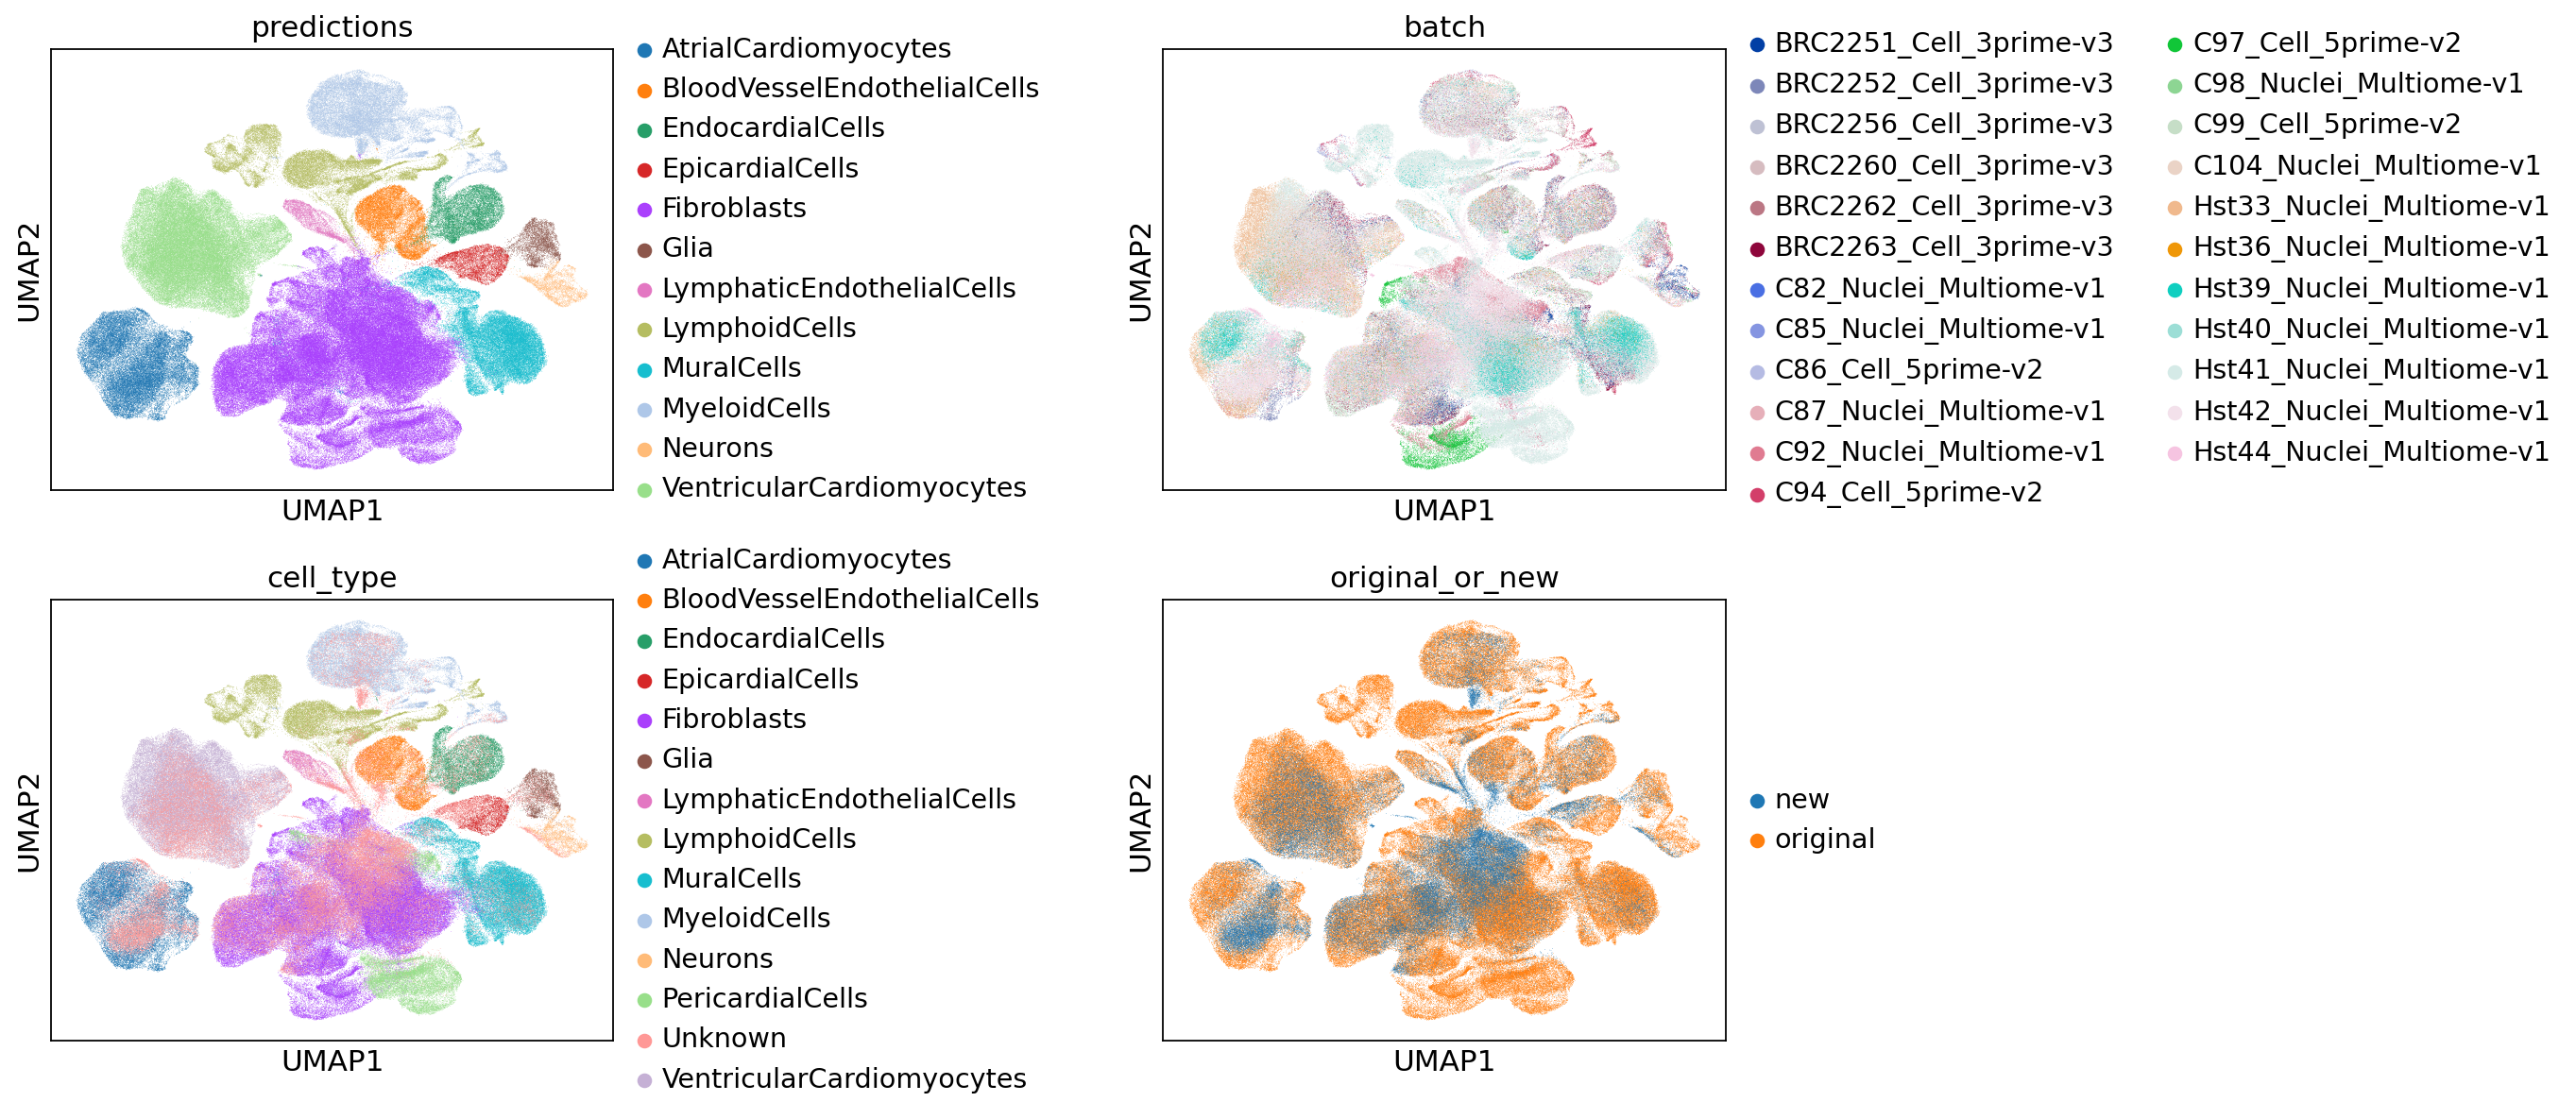

CPU times: user 14.5 s, sys: 638 ms, total: 15.2 s
Wall time: 15 s


In [38]:
%%time
sc.pl.umap(full_latent,
           color=["predictions","batch", "cell_type","original_or_new"],
           wspace=0.8,
           ncols=2
)

## Save full latent adata

In [39]:
# save
file_path=os.path.join(adata_path,f'{job_name}_full_latent.h5ad')
full_latent.write(file_path)